# Using Machine Learning to Forecast Air Quality in Beijing

### 1 - Import Python Packages

In [1]:
# Beijing PM 2.5
# Springboard Capstone Project I

%matplotlib inline
import pandas as pd
import numpy as np
import math
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import scipy.stats as st
from scipy.stats.stats import pearsonr

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

### 2 - Data Wrangling & Exploratory Data Analysis

In [2]:
# Data obtained from UCI Repository (https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)
df_Beijing = pd.read_csv('BeijingPM20100101_20151231.csv')
df_Beijing.info()
df_Beijing.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 18 columns):
No                 52584 non-null int64
year               52584 non-null int64
month              52584 non-null int64
day                52584 non-null int64
hour               52584 non-null int64
season             52584 non-null int64
PM_Dongsi          25052 non-null float64
PM_Dongsihuan      20508 non-null float64
PM_Nongzhanguan    24931 non-null float64
PM_US Post         50387 non-null float64
DEWP               52579 non-null float64
HUMI               52245 non-null float64
PRES               52245 non-null float64
TEMP               52579 non-null float64
cbwd               52579 non-null object
Iws                52579 non-null float64
precipitation      52100 non-null float64
Iprec              52100 non-null float64
dtypes: float64(11), int64(6), object(1)
memory usage: 7.2+ MB


,No,year,month,day,hour,season,PM_Dongsi,PM_Dongsihuan,PM_Nongzhanguan,PM_US Post,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec
0,1,2010,1,1,0,4,NaN,NaN,NaN,NaN,-21.0,43.0,1021.0,-11.0,NW,1.79,0.0,0.0
1,2,2010,1,1,1,4,NaN,NaN,NaN,NaN,-21.0,47.0,1020.0,-12.0,NW,4.92,0.0,0.0
2,3,2010,1,1,2,4,NaN,NaN,NaN,NaN,-21.0,43.0,1019.0,-11.0,NW,6.71,0.0,0.0
3,4,2010,1,1,3,4,NaN,NaN,NaN,NaN,-21.0,55.0,1019.0,-14.0,NW,9.84,0.0,0.0
4,5,2010,1,1,4,4,NaN,NaN,NaN,NaN,-20.0,51.0,1018.0,-12.0,NW,12.97,0.0,0.0


In [3]:
# Index dataframe using datetime
df_Beijing.index = pd.to_datetime(df_Beijing.year*1000000 + df_Beijing.month*10000 + df_Beijing.day*100 + df_Beijing.hour, format='%Y%m%d%H')

In [4]:
# Rename columns to be easily recognizable
df_Beijing = df_Beijing.rename(columns={'PM_US Post': 'pm25', 'DEWP': 'dew_point',
                       'HUMI': 'humidity', 'PRES': 'pressure',
                       'TEMP' : 'temp', 'cbwd': 'wind_dir',
                       'Iws': 'wind_speed'})
df = df_Beijing.copy()

In [5]:
# Separately wrangle data wind speed and direction
df_wind = df.loc[:,'wind_dir':'wind_speed']
df = df.loc[:,'pm25':'precipitation']
df = df.drop(['wind_dir','wind_speed'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 6 columns):
pm25             50387 non-null float64
dew_point        52579 non-null float64
humidity         52245 non-null float64
pressure         52245 non-null float64
temp             52579 non-null float64
precipitation    52100 non-null float64
dtypes: float64(6)
memory usage: 2.8 MB


In [7]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 2 columns):
wind_dir      52579 non-null object
wind_speed    52579 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [8]:
# Generate one column per direction (NW, NE, SE, SW) with the wind speed as the value in each column
df_wind = df_wind.pivot(columns='wind_dir', values='wind_speed')

In [9]:
# Finish cleaning df_wind
df_wind = df_wind.rename(columns={'cv': 'SW'})
df_wind = df_wind.loc[:,'NE':'SW']
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 4 columns):
NE    6178 non-null float64
NW    16717 non-null float64
SE    18272 non-null float64
SW    11412 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB


In [10]:
# Replace all NaN with zero
df_wind.fillna(0, inplace=True)

In [11]:
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52584 entries, 2010-01-01 00:00:00 to 2015-12-31 23:00:00
Data columns (total 4 columns):
NE    52584 non-null float64
NW    52584 non-null float64
SE    52584 non-null float64
SW    52584 non-null float64
dtypes: float64(4)
memory usage: 2.0 MB


In [12]:
# Join df_wind to the main dataframe df
df = pd.concat([df, df_wind], axis=1)

In [13]:
# The data now contains one observation per row with one feature per column
df.head()

,pm25,dew_point,humidity,pressure,temp,precipitation,NE,NW,SE,SW
2010-01-01 00:00:00,NaN,-21.0,43.0,1021.0,-11.0,0.0,0.0,1.79,0.0,0.0
2010-01-01 01:00:00,NaN,-21.0,47.0,1020.0,-12.0,0.0,0.0,4.92,0.0,0.0
2010-01-01 02:00:00,NaN,-21.0,43.0,1019.0,-11.0,0.0,0.0,6.71,0.0,0.0
2010-01-01 03:00:00,NaN,-21.0,55.0,1019.0,-14.0,0.0,0.0,9.84,0.0,0.0
2010-01-01 04:00:00,NaN,-20.0,51.0,1018.0,-12.0,0.0,0.0,12.97,0.0,0.0


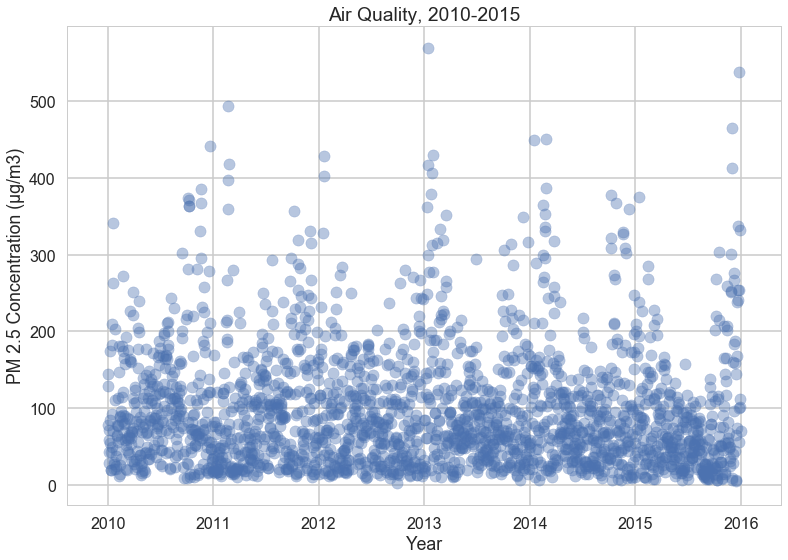

In [14]:
# Generate a simple scatter plot of daily mean PM2.5 concentration for entire time span
scatter_y = df.pm25.resample('D').mean()
scatter_x = df.pm25.resample('D').mean().index
#color = scatter_y

plt.scatter(x = scatter_x, y = scatter_y, alpha = 0.4)
plt.xlabel('Year')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality, 2010-2015')

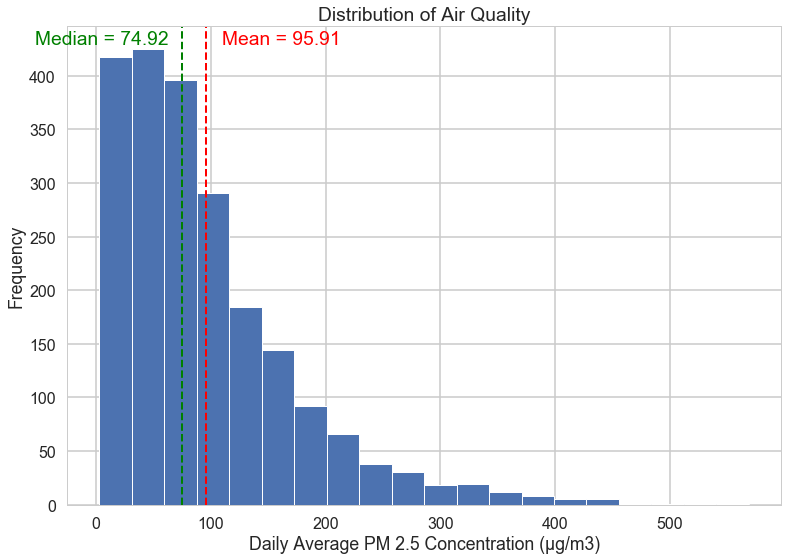

In [15]:
# Distribution of air quality for the period 2010-2015
plt.figure()
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)

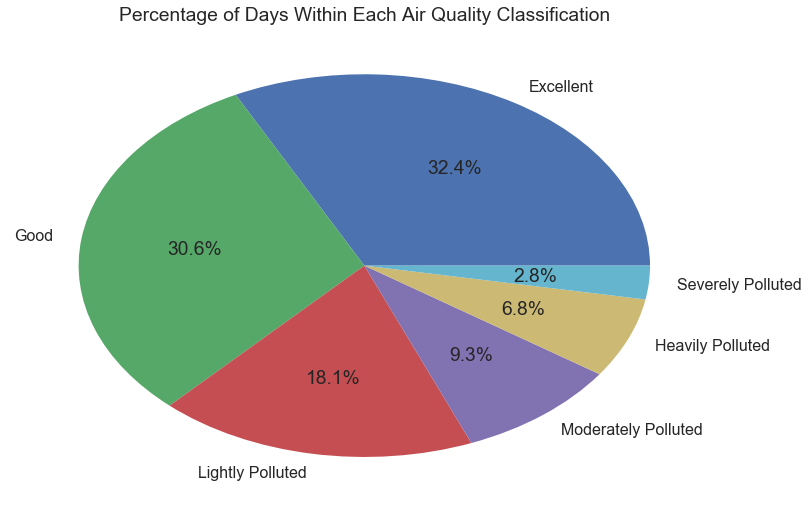

In [16]:
# Generate a pie chart to show portion of days falling into each air quality classification
excellent = len([ii for ii in scatter_y.dropna() if ii <= 50])
good = len([ii for ii in scatter_y.dropna() if ii > 50 and ii <= 100])
lightly = len([ii for ii in scatter_y.dropna() if ii > 100 and ii <= 150])
moderately = len([ii for ii in scatter_y.dropna() if ii > 150 and ii <= 200])
heavily = len([ii for ii in scatter_y.dropna() if ii > 200 and ii <= 300])
severely = len([ii for ii in scatter_y.dropna() if ii > 300])
sizes = [excellent, good, lightly, moderately, heavily, severely]
labels = ['Excellent','Good','Lightly Polluted','Moderately Polluted','Heavily Polluted','Severely Polluted']
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Percentage of Days Within Each Air Quality Classification')

([<matplotlib.axis.XTick at 0x115326c18>,
 <a list of 12 Text xticklabel objects>)

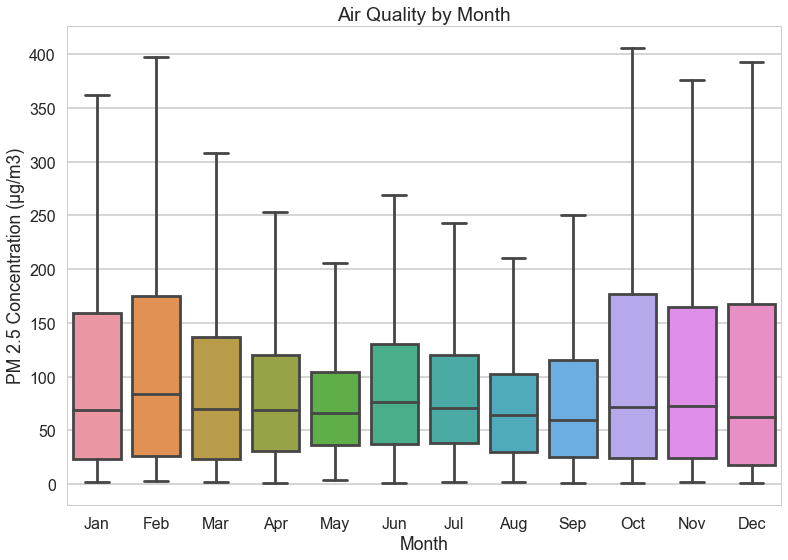

In [17]:
# Plot PM 2.5 level by MONTH
plt.figure()
sns.boxplot(x="month", y="pm25", data=df_Beijing, showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])

([<matplotlib.axis.XTick at 0x11ab4c710>,
 <a list of 7 Text xticklabel objects>)

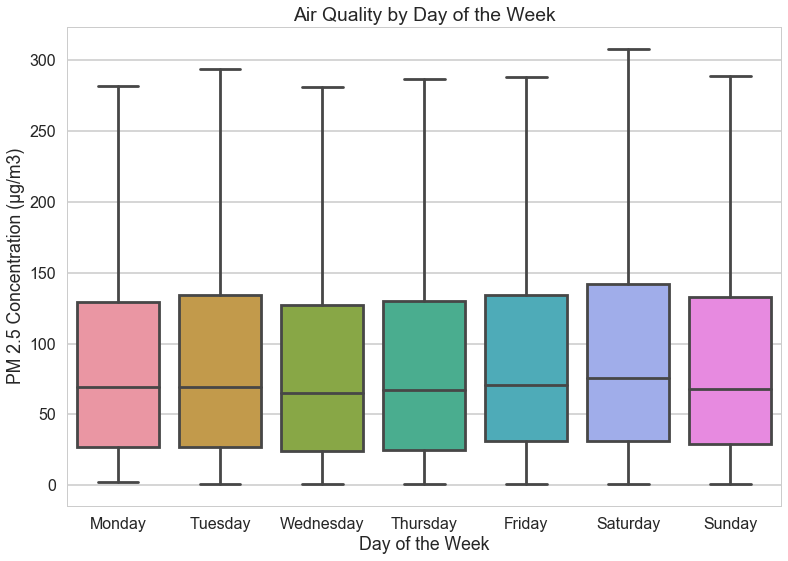

In [18]:
# Plot PM 2.5 level by DAY OF THE WEEK
df_length = df_Beijing.shape[0]

weekday = []

for ii in list(range(df_length)):
    weekday.append(calendar.weekday(df_Beijing.year[ii],
        df_Beijing.month[ii], df_Beijing.day[ii]))
    
df['weekday'] = weekday

plt.figure()
sns.boxplot(x="weekday", y="pm25", data=df, showfliers=False)
plt.xlabel('Day of the Week')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day of the Week')
plt.xticks(range(0,7), calendar.day_name)

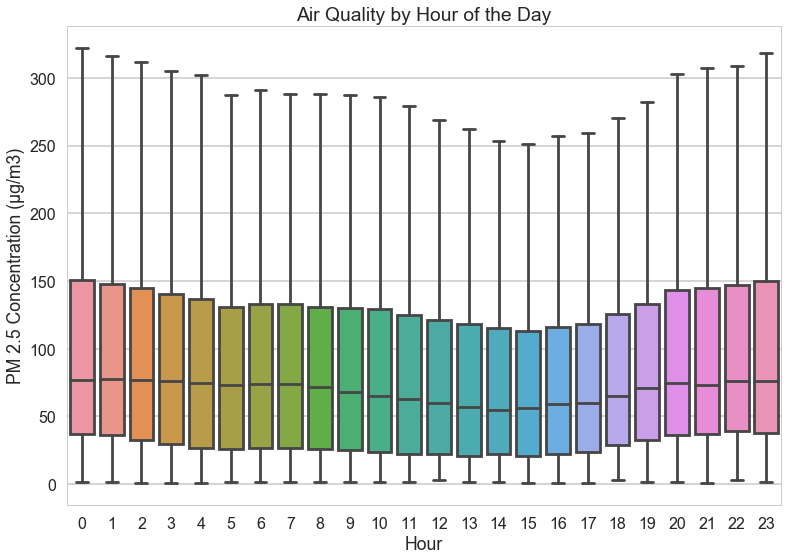

In [19]:
# Plot PM 2.5 level by HOUR OF THE DAY

plt.figure()
sns.boxplot(x="hour", y="pm25", data=df_Beijing, showfliers=False)
plt.xlabel('Hour')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Hour of the Day')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


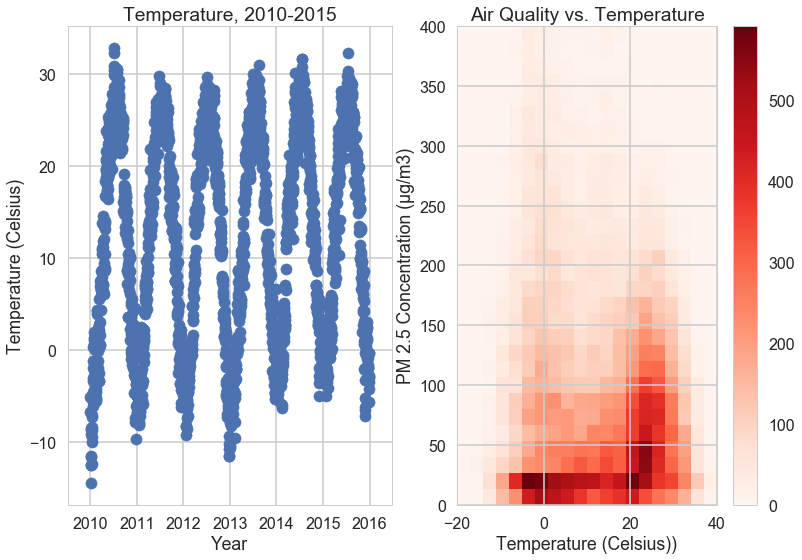

In [20]:
# Now we take a look at the other features apart from air concentration:

# Temperature

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.temp.resample('D').mean().index, y = df.temp.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Temperature (Celsius)')
plt.title('Temperature, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.temp, y = df.pm25, bins = (20, 30), range = ((-20,40),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Temperature (Celsius))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Temperature')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


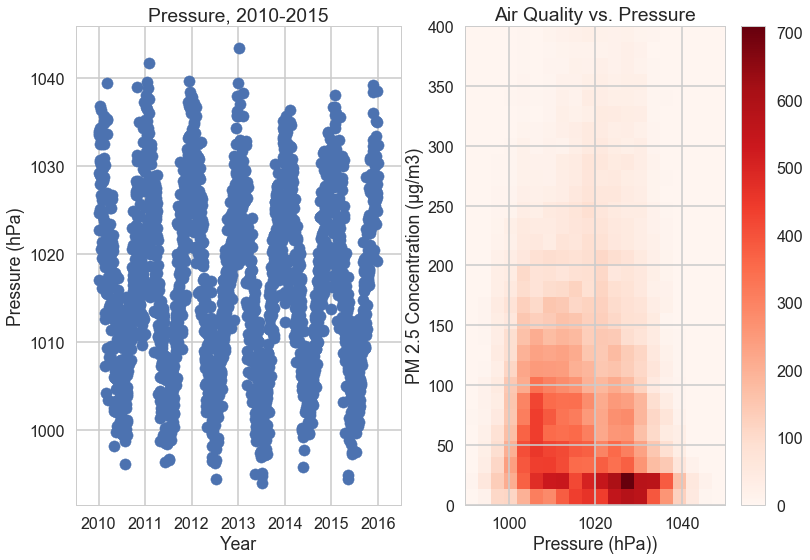

In [21]:
# Pressure

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.pressure.resample('D').mean().index, y = df.pressure.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Pressure (hPa)')
plt.title('Pressure, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.pressure, y = df.pm25, bins = (20, 30), range = ((990,1050),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Pressure (hPa))')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Pressure')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


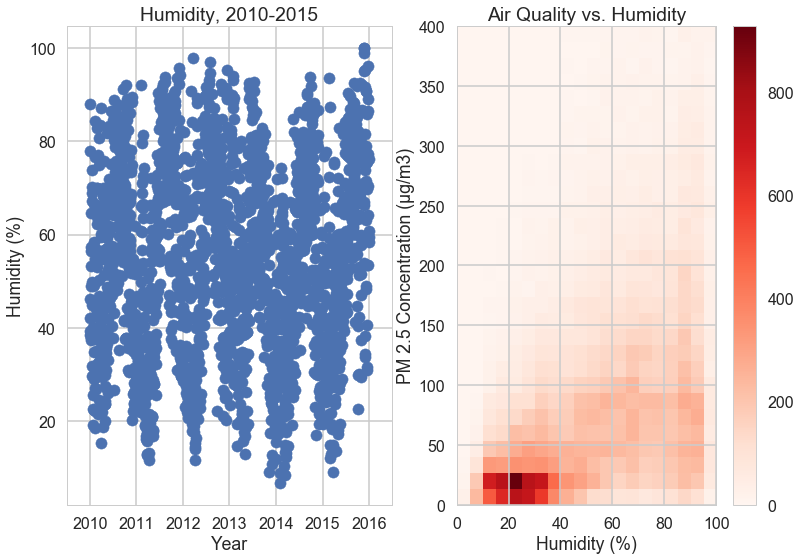

In [22]:
# Humidity

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.humidity.resample('D').mean().index, y = df.humidity.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Humidity (%)')
plt.title('Humidity, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.humidity, y = df.pm25, bins = (20, 30), range = ((0,100),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Humidity (%)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Humidity')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


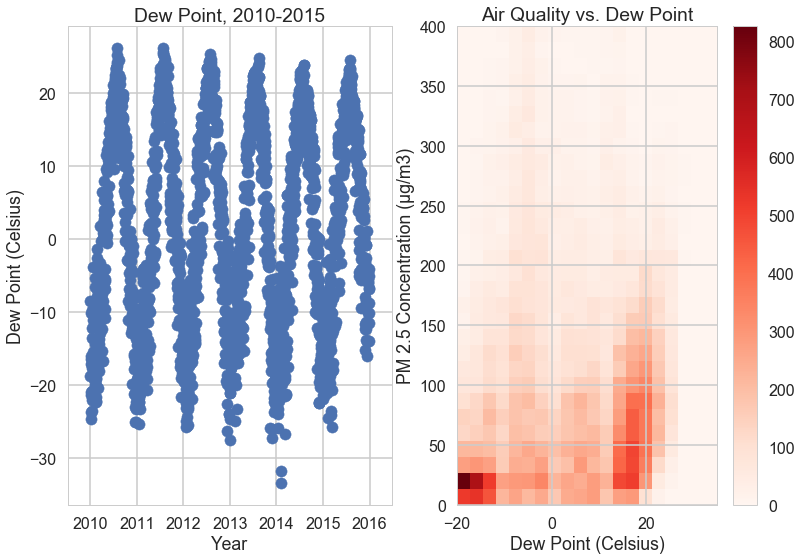

In [23]:
# Dew Point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.dew_point.resample('D').mean().index, y = df.dew_point.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Dew Point (Celsius)')
plt.title('Dew Point, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.dew_point, y = df.pm25, bins = (20, 30), range = ((-20,35),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Dew Point (Celsius)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Dew Point')

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


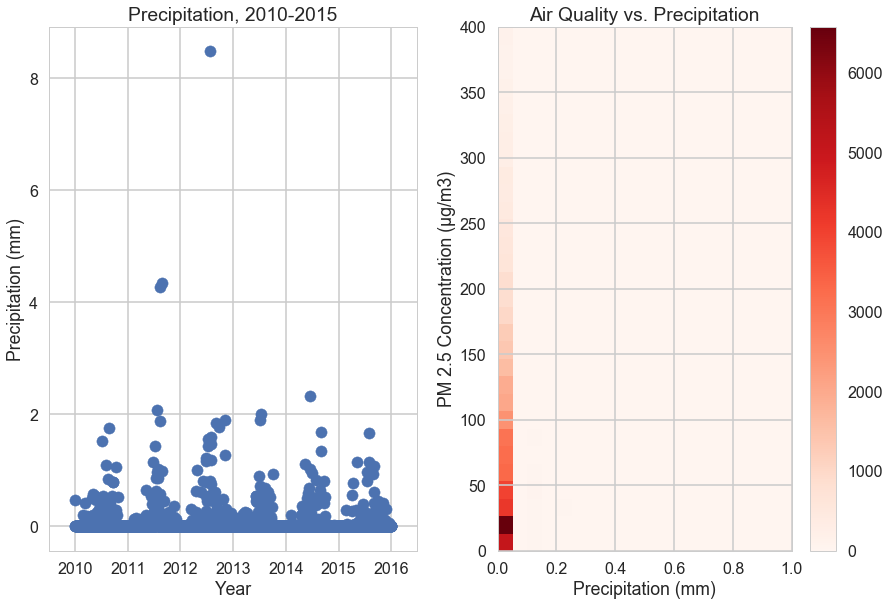

In [24]:
# Precipitation

df.precipitation[df.precipitation >= 1000] = np.nan  # Remove erroneous 999990.0 point

plt.figure()
plt.subplot(1,2,1)
plt.scatter(x = df.precipitation.resample('D').mean().index, y = df.precipitation.resample('D').mean())
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation, 2010-2015')

plt.subplot(1,2,2)
plt.hist2d(x = df.precipitation, y = df.pm25,
           bins = (20, 30), range = ((0,1),(0,400)), cmap = 'Reds')
plt.colorbar()
plt.xlabel('Precipitation (mm)')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality vs. Precipitation')

plt.tight_layout()

([<matplotlib.axis.YTick at 0x11748e710>,
 <a list of 6 Text yticklabel objects>)

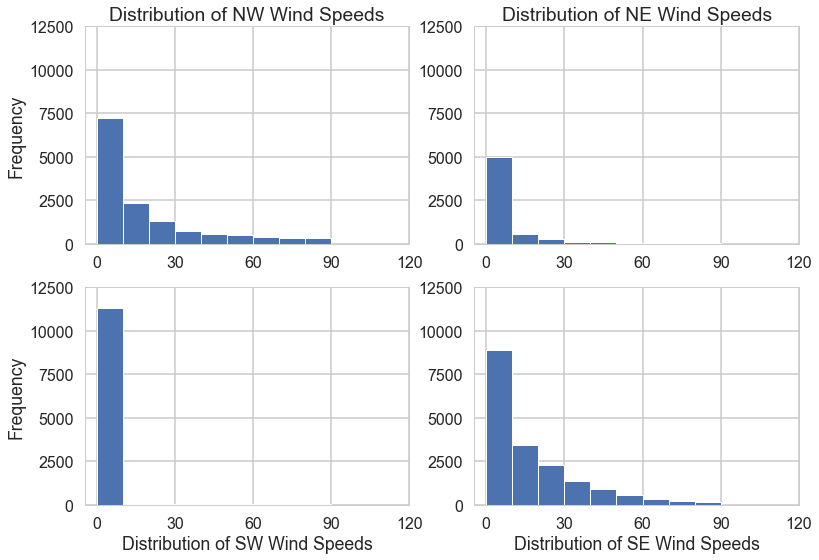

In [25]:
# Wind Speed Sorted by Wind Direction

# NW

plt.figure()
plt.subplot(2,2,1)
plt.hist(df.NW[df.NW > 0], bins = range(0,100,10), edgecolor='w', lw=1)
plt.ylabel('Frequency')
plt.title('Distribution of NW Wind Speeds')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

# NE

plt.subplot(2,2,2)
plt.hist(df.NE[df.NE > 0], bins = range(0,100,10), edgecolor='w', lw=1)
plt.title('Distribution of NE Wind Speeds')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

# SW

plt.subplot(2,2,3)
plt.hist(df.SW[df.SW > 0], bins = range(0,100,10), edgecolor='w', lw=1)
plt.xlabel('Distribution of SW Wind Speeds')
plt.ylabel('Frequency')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

# SE

plt.subplot(2,2,4)
plt.hist(df.SE[df.SE > 0], bins = range(0,100,10), edgecolor='w', lw=1)
plt.xlabel('Distribution of SE Wind Speeds')
plt.xticks(np.arange(0,150,30))
plt.yticks(np.arange(0,15000,2500))

/Users/kevinlimkrailassiri/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


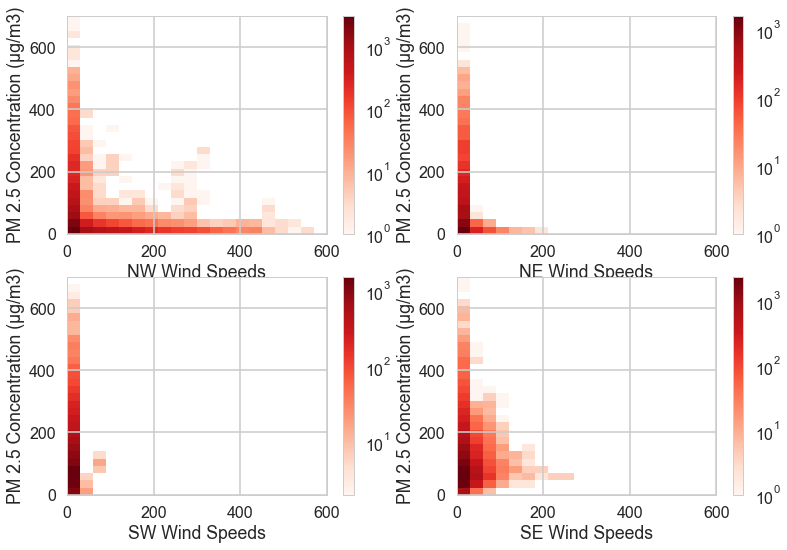

In [26]:
# Correlation between air concentration and wind direction:

# NW

plt.figure()
plt.subplot(2,2,1)
plt.hist2d(x = df.NW[df.NW > 0], y = df.pm25[df.NW > 0],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('NW Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

# NE

plt.subplot(2,2,2)
plt.hist2d(x = df.NE[df.NE > 0], y = df.pm25[df.NE > 0],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('NE Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

# SW

plt.subplot(2,2,3)
plt.hist2d(x = df.SW[df.SW > 0], y = df.pm25[df.SW > 0],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('SW Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

# SE

plt.subplot(2,2,4)
plt.hist2d(x = df.SE[df.SE > 0], y = df.pm25[df.SE > 0],
           bins = (20, 30), range = ((0,600),(0,700)), cmap = 'Reds', norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel('SE Wind Speeds')
plt.ylabel('PM 2.5 Concentration (μg/m3)')

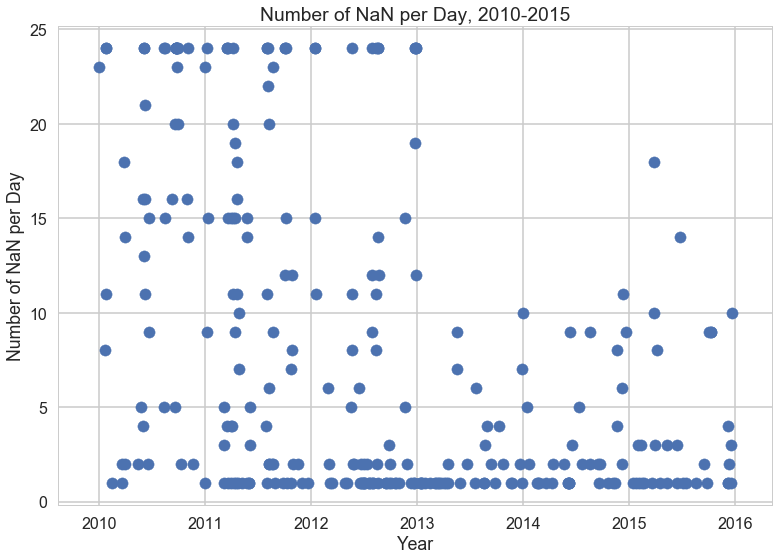

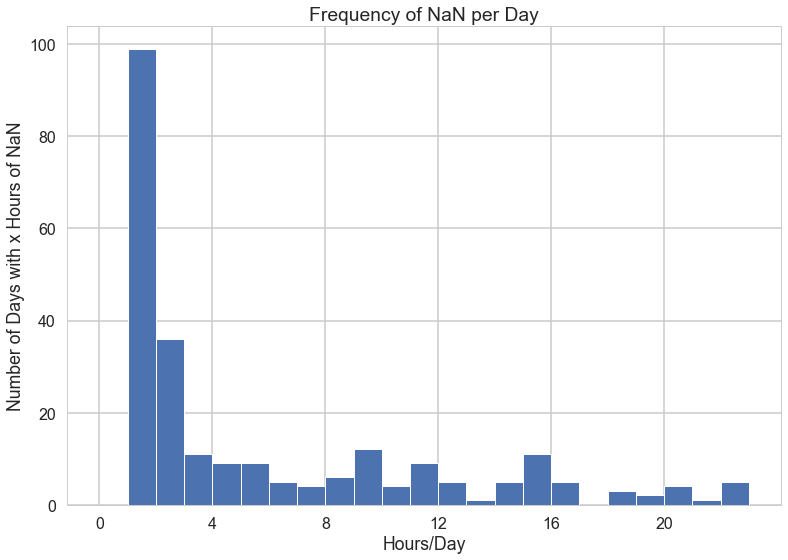

In [27]:
# How reliable is this measurement center? Also, how frequently do NaN appear each day?

dailyNaN = df.pm25.isnull().resample('D').sum()

plt.figure()
plt.title('Number of NaN per Day, 2010-2015')
plt.scatter(x = dailyNaN[dailyNaN > 0].index, y = dailyNaN[dailyNaN > 0])
plt.xlabel('Year')
plt.ylabel('Number of NaN per Day')

plt.figure()
plt.title('Frequency of NaN per Day')
plt.hist(dailyNaN[dailyNaN > 0], bins=range(0,24,1), edgecolor='w', lw=1)
plt.xticks(np.arange(0,24,4))
plt.xlabel('Hours/Day')
plt.ylabel('Number of Days with x Hours of NaN')

In [28]:
# Function consecNaN() constructs a list of the number of hours that the NaN's appear consecutively:
def consecNaN(NaNorNot):
    consecutive = []
    counter = 0
    before = False
    for ii in NaNorNot:
        if ii == True:
            if before == False:
                counter = 1
            else:
                counter += 1
            before = True
        else:
            if before == True:
                consecutive.append(counter)
            before = False
    return consecutive

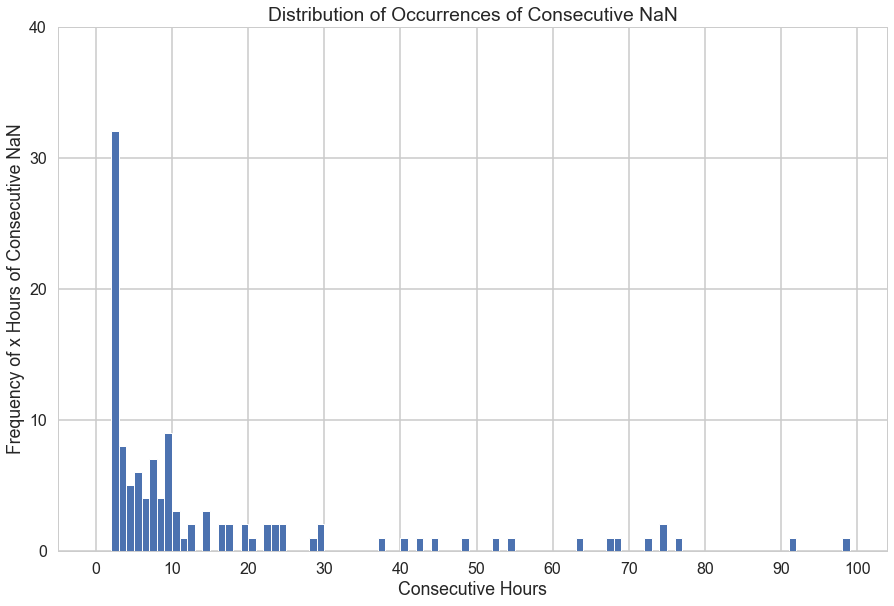

In [29]:
consecNaN_dist = consecNaN(df.pm25.isnull())
consecNaN_dist_over1 = [ii for ii in consecNaN_dist if ii > 1]

plt.figure()
plt.hist(consecNaN_dist_over1, bins=range(0,100,1), edgecolor='w', lw=1)
plt.title('Distribution of Occurrences of Consecutive NaN')
plt.xticks(np.arange(0,110,10))
plt.xlabel('Consecutive Hours')
plt.ylabel('Frequency of x Hours of Consecutive NaN')
plt.yticks(np.arange(0,50,10))
plt.tight_layout()

In [30]:
# Now, we find the days with more than 2 NaN and remove them

more_than_2hrs = df.pm25.isnull().resample('D').sum() > 2
more_than_2hrs = more_than_2hrs[more_than_2hrs == True]

In [31]:
df_more_than_2hrs = []

for ii in more_than_2hrs.index:
    df_more_than_2hrs.append(df[str(datetime.date(ii))])
    
df_more_than_2hrs = pd.concat(df_more_than_2hrs, axis = 1)

In [32]:
# Drop the days with more than 2 hrs of NaN

df = df.drop(df_more_than_2hrs.index)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49056 entries, 2010-01-02 00:00:00 to 2015-12-31 23:00:00
Data columns (total 11 columns):
pm25             48885 non-null float64
dew_point        49052 non-null float64
humidity         48718 non-null float64
pressure         48718 non-null float64
temp             49052 non-null float64
precipitation    48611 non-null float64
NE               49056 non-null float64
NW               49056 non-null float64
SE               49056 non-null float64
SW               49056 non-null float64
weekday          49056 non-null int64
dtypes: float64(10), int64(1)
memory usage: 4.5 MB


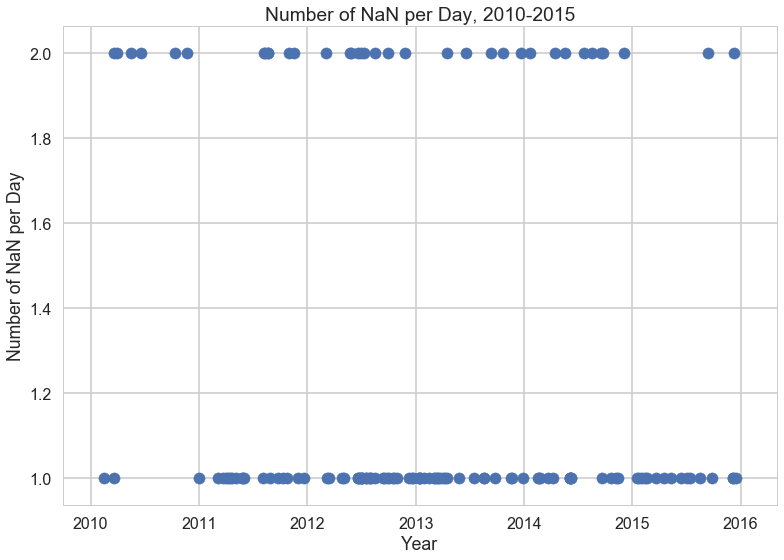

In [34]:
# This plot shows that all days with more than 2 NaN have been removed, as desired

dailyNaN2 = df.pm25.isnull().resample('D').sum()

plt.figure()
plt.title('Number of NaN per Day, 2010-2015')
plt.scatter(x = dailyNaN2[dailyNaN2 > 0].index, y = dailyNaN2[dailyNaN2 > 0])
plt.xlabel('Year')
plt.ylabel('Number of NaN per Day')

In [35]:
# The data is made available in two formats: hourly and daily.
# After the days with more than 2 NaN were moved, the remaining NaN were resolved with linear interpolation
df_hourly = df.interpolate(method='linear',axis=0)
df_daily = df.resample('D').mean()
df_daily = df_daily.interpolate(method='linear',axis=0)

In [36]:
df_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49056 entries, 2010-01-02 00:00:00 to 2015-12-31 23:00:00
Data columns (total 11 columns):
pm25             49056 non-null float64
dew_point        49056 non-null float64
humidity         49056 non-null float64
pressure         49056 non-null float64
temp             49056 non-null float64
precipitation    49056 non-null float64
NE               49056 non-null float64
NW               49056 non-null float64
SE               49056 non-null float64
SW               49056 non-null float64
weekday          49056 non-null int64
dtypes: float64(10), int64(1)
memory usage: 4.5 MB


In [37]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2190 entries, 2010-01-02 to 2015-12-31
Freq: D
Data columns (total 11 columns):
pm25             2190 non-null float64
dew_point        2190 non-null float64
humidity         2190 non-null float64
pressure         2190 non-null float64
temp             2190 non-null float64
precipitation    2190 non-null float64
NE               2190 non-null float64
NW               2190 non-null float64
SE               2190 non-null float64
SW               2190 non-null float64
weekday          2190 non-null float64
dtypes: float64(11)
memory usage: 205.3 KB


### 3 - Machine Learning

#### 3.1 - Linear Regression

In [38]:
#### Linear Regression

# Import the necessary modules
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Construct X and y

y = df_hourly['pm25'].values
X = df_hourly.loc[:,['temp','humidity','pressure','dew_point','precipitation','NW','NE','SE','SW']].values

#print(y.shape,X.shape)

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X,y,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[ 0.21117787  0.25186415 -0.00972543  0.18356477  0.20536018]
Average 5-Fold CV Score: 0.1684483083179376


In [39]:
# Ridge Regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size = 0.3, random_state = 42)
scores_ridge = []
alphas = [0.0001]
for alpha in alphas:
    ridge = Ridge(alpha=alpha, normalize=True)
    ridge.fit(X_train_reg, y_train_reg)
    ridge_pred = ridge.predict(X_test_reg)
    scores_ridge.append(ridge.score(X_test_reg, y_test_reg))
print(scores_ridge)

[0.24158596002335264]


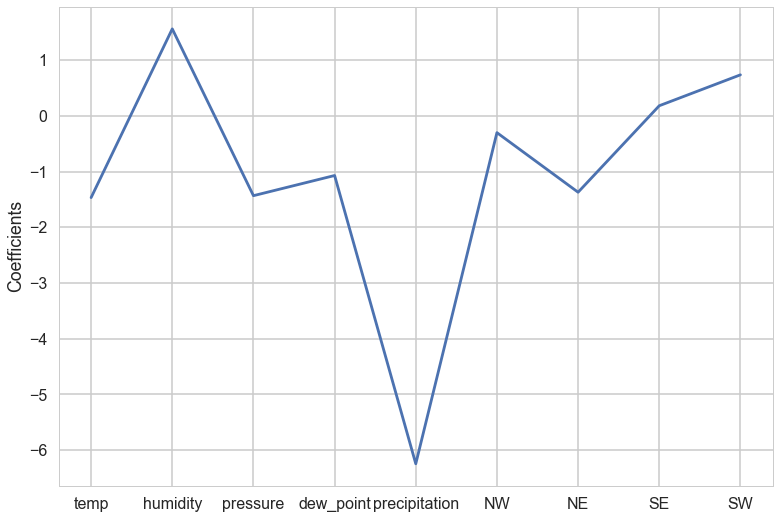

In [40]:
# Ridge for Feature Selection
names = ['temp','humidity','pressure','dew_point','precipitation','NW','NE','SE','SW']
Ridge = Ridge(alpha = 0.001)
ridge_coef = ridge.fit(X, y).coef_
plt.plot(range(len(names)), ridge_coef)
plt.xticks(range(len(names)), names)
plt.ylabel('Coefficients')
plt.show()

In [41]:
# Lasso Regression
from sklearn.linear_model import Lasso
scores_lasso = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, normalize=True)
    lasso.fit(X_train_reg, y_train_reg)
    lasso_pred = lasso.predict(X_test_reg)
    scores_lasso.append(lasso.score(X_test_reg, y_test_reg))
print(scores_lasso)

[0.241547318365257]


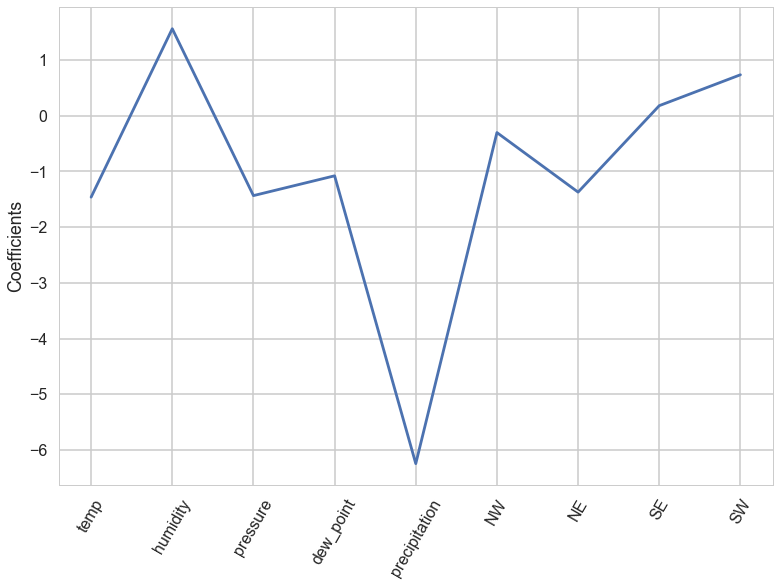

In [42]:
# Lasso for Feature Selection
names = ['temp','humidity','pressure','dew_point','precipitation','NW','NE','SE','SW']
lasso = Lasso(alpha = 0.0001)
lasso_coef = lasso.fit(X, y).coef_
plt.plot(range(len(names)), lasso_coef)
plt.xticks(range(len(names)), names, rotation=60)
plt.ylabel('Coefficients')
plt.show()

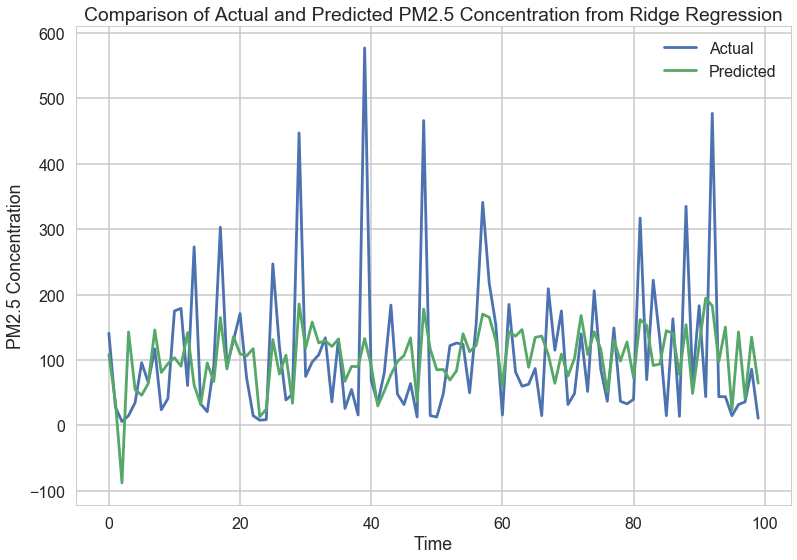

In [43]:
# Plot actual and predicted PM2.5 concentration based on ridge regression.

plt.plot(y_test_reg[0:100], label='Actual')
plt.plot(ridge_pred[0:100], label='Predicted')
plt.legend()

plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Comparison of Actual and Predicted PM2.5 Concentration from Ridge Regression')

In [44]:
# Calculate RMSE for ridge regression model

np.sqrt(mean_squared_error(y_test_reg, ridge_pred))

80.694846211043711

In [45]:
## Linear Regression, NW winds

# Construct X and y

y_NW = df_hourly['pm25'][df_hourly.NW > 0].values
X_NW = df_hourly[df_hourly.NW > 0].loc[:,['temp','humidity','pressure','dew_point','precipitation','NW']].values

print(y_NW.shape,X_NW.shape)

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X_NW,y_NW,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score for NW Winds: {}".format(np.mean(cv_scores)))

(15629,) (15629, 6)
[ 0.32168415  0.32436448  0.32234208  0.22543283  0.25674274]
Average 5-Fold CV Score for NW Winds: 0.2901132568606728


In [46]:
## Linear Regression, NE winds

# Construct X and y

y_NE = df_hourly['pm25'][df_hourly.NE > 0].values
X_NE = df_hourly[df_hourly.NE > 0].loc[:,['temp','humidity','pressure','dew_point','precipitation','NE']].values

print(y_NE.shape,X_NE.shape)

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X_NE,y_NE,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score for NE Winds: {}".format(np.mean(cv_scores)))

(5763,) (5763, 6)
[ 0.28500524  0.17723706  0.37436082  0.24463908  0.21524917]
Average 5-Fold CV Score for NE Winds: 0.2592982743400033


In [47]:
## Linear Regression, SE winds

# Construct X and y

y_SE = df_hourly['pm25'][df_hourly.SE > 0].values
X_SE = df_hourly[df_hourly.SE > 0].loc[:,['temp','humidity','pressure','dew_point','precipitation','SE']].values

print(y_SE.shape,X_SE.shape)

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X_SE,y_SE,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score for SE Winds: {}".format(np.mean(cv_scores)))

(17004,) (17004, 6)
[ 0.00438617  0.16432326  0.1829159   0.13904221  0.14404889]
Average 5-Fold CV Score for SE Winds: 0.12694328755174106


In [48]:
## Linear Regression, SW winds

# Construct X and y

y_SW = df_hourly['pm25'][df_hourly.SW > 0].values
X_SW = df_hourly[df_hourly.SW > 0].loc[:,['temp','humidity','pressure','dew_point','precipitation','SW']].values

print(y_SW.shape,X_SW.shape)

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg,X_SW,y_SW,cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score for SW Winds: {}".format(np.mean(cv_scores)))

(10656,) (10656, 6)
[ 0.10161931  0.1856001  -0.51352422  0.14724744  0.21663323]
Average 5-Fold CV Score for SW Winds: 0.027515171542089358


#### 3.2 - Long Short-Term Memory (LSTM) Neural Networks

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.
/Users/kevinlimkrailassiri/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [50]:
# Generate df_LSTM to feed into LSTM model:
def create_LSTM(dataset, timesteps, features, targets):
    
    # dataset is the dataframe from which X and y will be extracted
    # timesteps is the number of time steps in the past that will be used to calculate y
    # features is the number of parameters in X
    # targets is the number of parameters in y
    # create_LSTM() outputs df_LSTM_X and df_LSTM_y
    
    df_LSTM = pd.DataFrame()
    for tt in range(-timesteps + 1, 1, 1):
        df_shifted_X = dataset[dataset.columns[0:features]].shift(-tt).copy()
        df_shifted_X.columns = ['X_' + var + '(t' + str(tt) + ')' for var in df_shifted_X.columns]
        for col in df_shifted_X.columns:
            df_LSTM[col] = df_shifted_X[col]
    df_shifted_y = dataset[dataset.columns[0:targets]].shift(-tt-1).copy()
    df_shifted_y.columns = ['y_' + var + '(t' + str(tt+1) + ')' for var in df_shifted_y.columns]
    for col in df_shifted_y.columns:
        df_LSTM[col] = df_shifted_y[col]
    df_LSTM.dropna(inplace=True)
    df_LSTM_X = df_LSTM[df_LSTM.columns[:-targets]]
    df_LSTM_y = df_LSTM[df_LSTM.columns[-targets:]]
    return(df_LSTM_X, df_LSTM_y)

(1270, 365, 3) (540, 365, 3)
Completing Epoch #1... Train RMSE = 77.85, Test RMSE = 77.31
Completing Epoch #2... Train RMSE = 77.76, Test RMSE = 77.06
Completing Epoch #3... Train RMSE = 77.72, Test RMSE = 76.99
Completing Epoch #4... Train RMSE = 77.7, Test RMSE = 76.94
Completing Epoch #5... Train RMSE = 77.68, Test RMSE = 76.89
Completing Epoch #6... Train RMSE = 77.66, Test RMSE = 76.84
Completing Epoch #7... Train RMSE = 77.64, Test RMSE = 76.78
Completing Epoch #8... Train RMSE = 77.61, Test RMSE = 76.69
Completing Epoch #9... Train RMSE = 77.56, Test RMSE = 76.56
Completing Epoch #10... Train RMSE = 77.51, Test RMSE = 76.44
Completing Epoch #11... Train RMSE = 77.46, Test RMSE = 76.36
Completing Epoch #12... Train RMSE = 77.41, Test RMSE = 76.27
Completing Epoch #13... Train RMSE = 77.35, Test RMSE = 76.15
Completing Epoch #14... Train RMSE = 77.26, Test RMSE = 75.98
Completing Epoch #15... Train RMSE = 77.17, Test RMSE = 75.78
Completing Epoch #16... Train RMSE = 77.06, Test RM

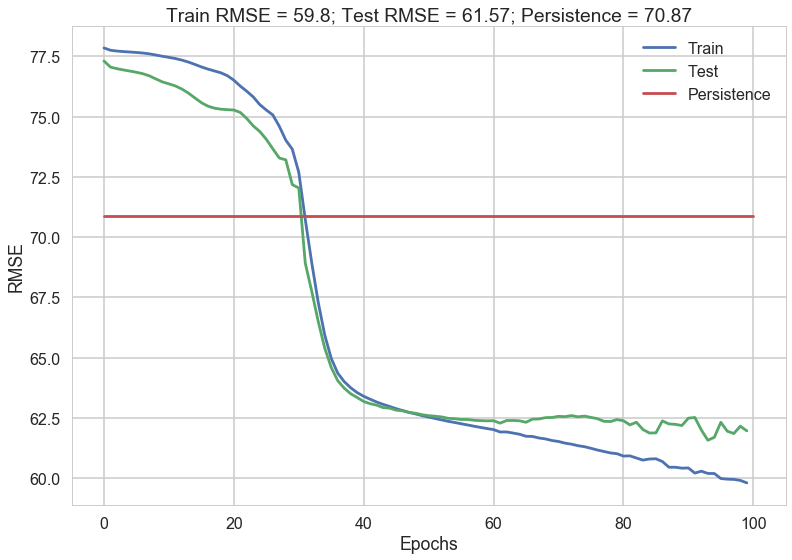

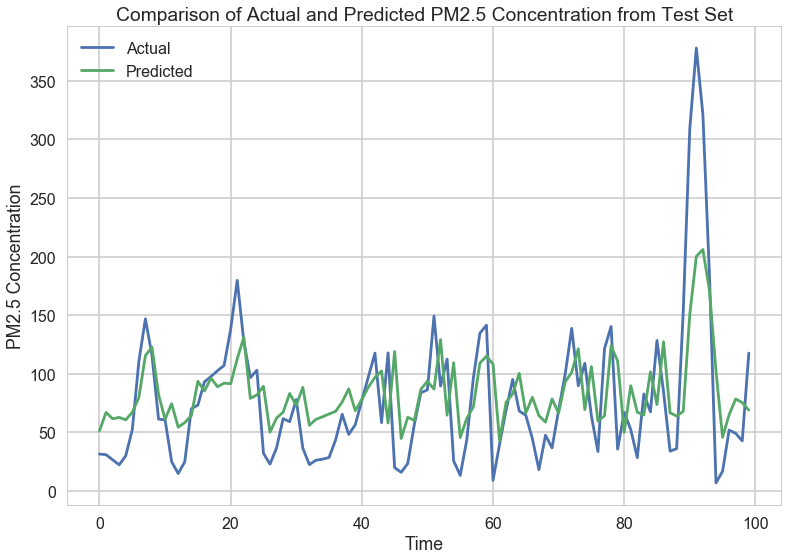

In [51]:
#### DESIGN NETWORK ####
timesteps = 365
features, targets = 3, 1

train_fraction = 0.7

batch_size = 10
neurons = 10
nb_epoch = 100
stacks = 3
########################

LSTM_X, LSTM_y = create_LSTM(df_daily, timesteps, features, targets)

normalizer_X = MinMaxScaler(feature_range = (0, 1))
normalizer_y = MinMaxScaler(feature_range = (0, 1))

normalized_X = normalizer_X.fit_transform(LSTM_X)
normalized_y = normalizer_y.fit_transform(LSTM_y)

train_rows = int(normalized_X.shape[0] * train_fraction/10)*10  # later replace '10' with batch_size?
test_rows = int(normalized_X.shape[0] * (1 - train_fraction)/10)*10

X_train = normalized_X[-(train_rows + test_rows):-test_rows, :]
y_train = normalized_y[-(train_rows + test_rows):-test_rows, :]

X_test = normalized_X[-test_rows:, :]
y_test = normalized_y[-test_rows:, :]

### Reshape into new array with (observations, timesteps, features)

X_train = X_train.reshape((train_rows, timesteps, features))
X_test = X_test.reshape((test_rows, timesteps, features))

print(X_train.shape, X_test.shape)

### Build model

model = Sequential()

if stacks == 1:
    model.add(LSTM(neurons, input_shape = (timesteps, features)))
elif stacks == 2:
    model.add(LSTM(neurons, batch_input_shape = (batch_size, timesteps, features), return_sequences = True, stateful = True))
    model.add(LSTM(neurons, stateful = True))
else:
    model.add(LSTM(neurons, batch_input_shape = (batch_size, timesteps, features), return_sequences = True, stateful = True))
    for ii in range(stacks - 2):
        model.add(LSTM(neurons, return_sequences = True, stateful = True))
    model.add(LSTM(neurons, stateful = True))      
    
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer = 'adam')

### Fit X and predict y

rmse_train, rmse_test, rmse_persistence = [], [], []

noninv_y_train = normalizer_y.inverse_transform(y_train)
noninv_y_test = normalizer_y.inverse_transform(y_test)
rmse_persistence = np.sqrt(mean_squared_error(noninv_y_test[:-1], noninv_y_test[1:]))

for ii in range(nb_epoch):
    model.fit(X_train, y_train, epochs = 1, batch_size = batch_size, verbose = 0, shuffle = False)
    y_train_predict = model.predict(X_train, batch_size = batch_size)
    y_test_predict = model.predict(X_test, batch_size = batch_size)
    
    # Inverse Transform all y's
    noninv_y_train_predict = normalizer_y.inverse_transform(y_train_predict)
    noninv_y_test_predict = normalizer_y.inverse_transform(y_test_predict)

    # Calculate RMSE
    rmse_train.append(np.sqrt(mean_squared_error(noninv_y_train, noninv_y_train_predict)))
    rmse_test.append(np.sqrt(mean_squared_error(noninv_y_test, noninv_y_test_predict)))
    
    print('Completing Epoch #' + str(ii + 1) + '... Train RMSE = ' + str(round(rmse_train[-1],2)) + ', Test RMSE = '
        + str(round(rmse_test[-1],2)))
    
    model.reset_states()

### Plot RMSE for train and test sets as function of epochs    
    
plt.figure()
plt.plot(rmse_train, label='Train')
plt.plot(rmse_test, label='Test')
plt.plot([0, nb_epoch], [rmse_persistence, rmse_persistence], label='Persistence')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Train RMSE = ' + str(round(min(rmse_train),2)) + '; Test RMSE = ' + str(round(min(rmse_test),2)) + '; Persistence = ' + str(round(rmse_persistence,2)))
#plt.text(nb_epoch/2, rmse_persistence-4, ' Prior time steps = ' + str(timesteps) + '\n Train fraction = ' + str(train_fraction) 
        #+ '\n Batch size = ' + str(batch_size) + '\n Neurons = ' + str(neurons) + '\n Epochs = ' + str(nb_epoch)
        #+ '\n Stacks = ' + str(stacks))

### Plot actual and predicted y

plt.figure()
plt.plot(noninv_y_test[0:100], label = 'Actual')
plt.plot(noninv_y_test_predict[0:100], label = 'Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Comparison of Actual and Predicted PM2.5 Concentration from Test Set')

In [52]:
# Prepare a dataframe to plot actual PM2.5 concentration with their predicted AQI classification

y_test_plot = pd.DataFrame(
    {'pm25actual': noninv_y_test.flatten(),
     'pm25predicted': noninv_y_test_predict.flatten()
    })

In [53]:
y_test_plot.head()

,pm25actual,pm25predicted
0,31.375000,51.210537
1,30.833333,66.932777
2,26.500000,61.528152
3,22.166667,62.659866
4,29.916667,60.579308


In [54]:
# Classifies the PM2.5 concentration into one of the 6 AQI classifications

def AQIclassifier(pm25):
    AQI = []
    for ii in pm25:
        if ii <= 50:
            AQI.append(1)
        elif ii > 50 and ii <= 100:
            AQI.append(2)
        elif ii > 100 and ii <= 150:
            AQI.append(3)
        elif ii > 150 and ii <= 200:
            AQI.append(4)
        elif ii > 200 and ii <= 300:
            AQI.append(5)
        else:
            AQI.append(6)
    return AQI

AQIactual = AQIclassifier(noninv_y_test)
AQIpredicted = AQIclassifier(noninv_y_test_predict)

In [55]:
y_test_plot['AQIactual'] = AQIactual
y_test_plot['AQIpredicted'] = AQIpredicted

In [56]:
# This is the number of points out of 540 that are correctly characterized by the LSTM model.

sum(y_test_plot['AQIactual'] == y_test_plot['AQIpredicted'])

168

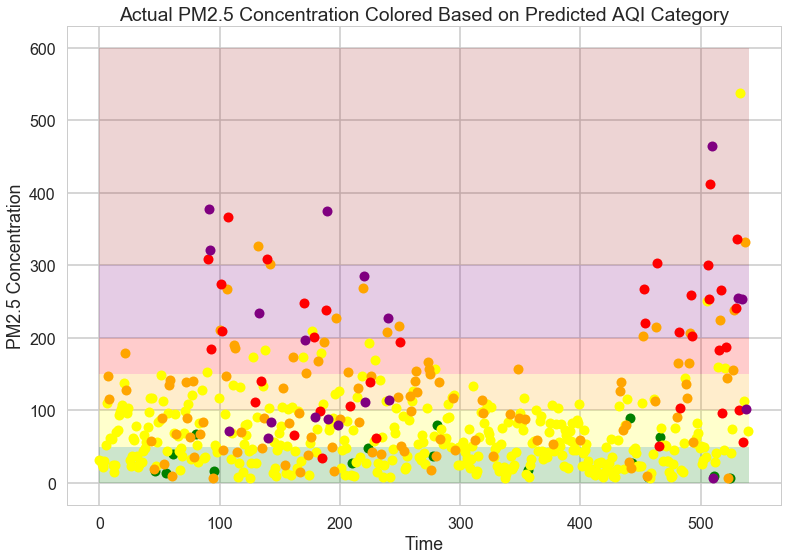

In [57]:
# Plot actual PM2.5 concentration with color based on the predicted AQI classification

fig, ax = plt.subplots()

ax.fill_between([0,540], 0, 50, facecolor='green', alpha = .2, interpolate=True)
ax.fill_between([0,540], 50, 100, facecolor='yellow', alpha = .2, interpolate=True)
ax.fill_between([0,540], 100, 150, facecolor='orange', alpha = .2, interpolate=True)
ax.fill_between([0,540], 150, 200, facecolor='red', alpha = .2, interpolate=True)
ax.fill_between([0,540], 200, 300, facecolor='purple', alpha = .2, interpolate=True)
ax.fill_between([0,540], 300, 600, facecolor='brown', alpha = .2, interpolate=True)

plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 1]['pm25actual'],'.',color='green',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 2]['pm25actual'],'.',color='yellow',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 3]['pm25actual'],'.',color='orange',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 4]['pm25actual'],'.',color='red',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 5]['pm25actual'],'.',color='purple',markersize = 20)
plt.plot(y_test_plot[y_test_plot['AQIpredicted'] == 6]['pm25actual'],'.',color='brown',markersize = 20)

plt.xlabel('Time')
plt.ylabel('PM2.5 Concentration')
plt.title('Actual PM2.5 Concentration Colored Based on Predicted AQI Category')